In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [2]:
import flax.linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import seaborn as sns
from flax.training import train_state
from jax import random

from neurovae import MLPVAE, gaussian_kld, load_mnist, mse_loss, sse_loss, plot_digits

sns.set_theme(context="paper", style="darkgrid", rc={"axes.facecolor": "0.96"})
fontsize = "x-large"
params = {
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "legend.handlelength": 2,
}
plt.rcParams.update(params)

In [3]:
def compute_metrics(recon_x, x, mean, logvar):
    mse = sse_loss(recon_x, x).mean()  # mean over batch
    kld = gaussian_kld(mean, logvar).mean()  # mean over batch
    elbo = mse + kld
    return {"elbo": float(elbo), "mse": float(mse), "kld": float(kld)}


def train_step(state, batch, z_rng, hidden_dim, latent_dim, output_dim):

    def loss_fn(params):
        recon_x, mean, logvar = MLPVAE(hidden_dim, latent_dim, output_dim).apply({"params": params}, batch, z_rng)
        mse = sse_loss(recon_x, batch).mean()
        kld = gaussian_kld(mean, logvar).mean()
        elbo = mse + kld
        return elbo

    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)


def eval_f(params, images, z, z_rng, epoch, hidden_dim, latent_dim, output_dim):
    def eval_model(vae):
        recon_images, mean, logvar = vae(images, z_rng)

        comparison = jnp.concatenate(
            [
                images[:8].reshape(-1, 28, 28, 1),
                recon_images[:8].reshape(-1, 28, 28, 1),
            ]
        )

        generate_images = vae.generate(z, assumption="gaussian")
        generate_images = generate_images.reshape(-1, 28, 28, 1)
        metrics = compute_metrics(recon_images, images, mean, logvar)
        metrics["epoch"] = epoch + 1
        return metrics, comparison, generate_images

    return nn.apply(eval_model, MLPVAE(hidden_dim, latent_dim, output_dim))({"params": params})

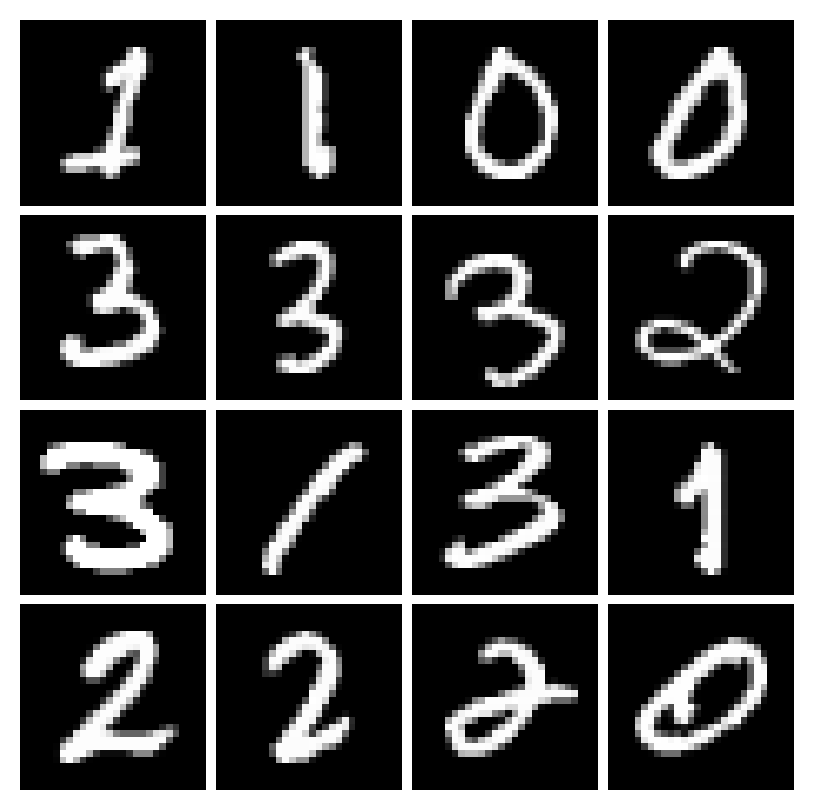

In [4]:
learning_rate = 0.001
hidden_dim = 500
latent_dim = 20
output_dim = 784
batch_size = 64
num_epochs = 5
seed = 42

batches, ds_test = load_mnist(
    batch_size=batch_size,
    drop_remainder=True,
    select_digits=[0, 1, 2, 3],
    as_supervised=False,
    binarized=False,
    shuffle=True,
    shuffle_seed=42,
)

jax.device_put(ds_test)

plot_digits(batches[0][:16], cmap="gray")
plt.show()

In [5]:
rng = random.key(seed)
rng, init_key = random.split(rng)

initial_variables = jnp.ones((batch_size, output_dim), jnp.float32)
params = MLPVAE(hidden_dim, latent_dim, output_dim).init(init_key, initial_variables, rng)["params"]
del initial_variables, init_key

state = train_state.TrainState.create(
    apply_fn=MLPVAE(hidden_dim, latent_dim, output_dim).apply,
    params=params,
    tx=optax.adam(learning_rate),
)

rng, z_key, eval_rng = random.split(rng, 3)

z = random.normal(z_key, (batch_size, latent_dim))
del z_key

In [6]:
metrics_store = []

for epoch in range(num_epochs):
    for batch in batches:
        rng, key = random.split(rng)
        state = train_step(state, batch, key, hidden_dim, latent_dim, output_dim)

    metrics, comparison, sample = eval_f(state.params, ds_test, z, eval_rng, epoch, hidden_dim, latent_dim, output_dim)
    metrics_store.append(metrics)
    print(f"epoch: {epoch + 1}, ELBO: {metrics['elbo']:.4f}, MSE: {metrics['mse']:.4f}, KLD: {metrics['kld']:.4f}")

epoch: 1, ELBO: 50.6913, MSE: 32.1418, KLD: 18.5495
epoch: 2, ELBO: 41.9580, MSE: 27.4311, KLD: 14.5268
epoch: 3, ELBO: 37.3131, MSE: 25.0047, KLD: 12.3084
epoch: 4, ELBO: 34.7754, MSE: 23.7665, KLD: 11.0088
epoch: 5, ELBO: 33.3315, MSE: 22.1808, KLD: 11.1506


In [7]:
df = pd.DataFrame(metrics_store)
df

,elbo,mse,kld,epoch
0,50.691280,32.141777,18.549503,1
1,41.957966,27.431126,14.526840,2
2,37.313053,25.004669,12.308383,3
3,34.775368,23.766548,11.008820,4
4,33.331467,22.180845,11.150621,5


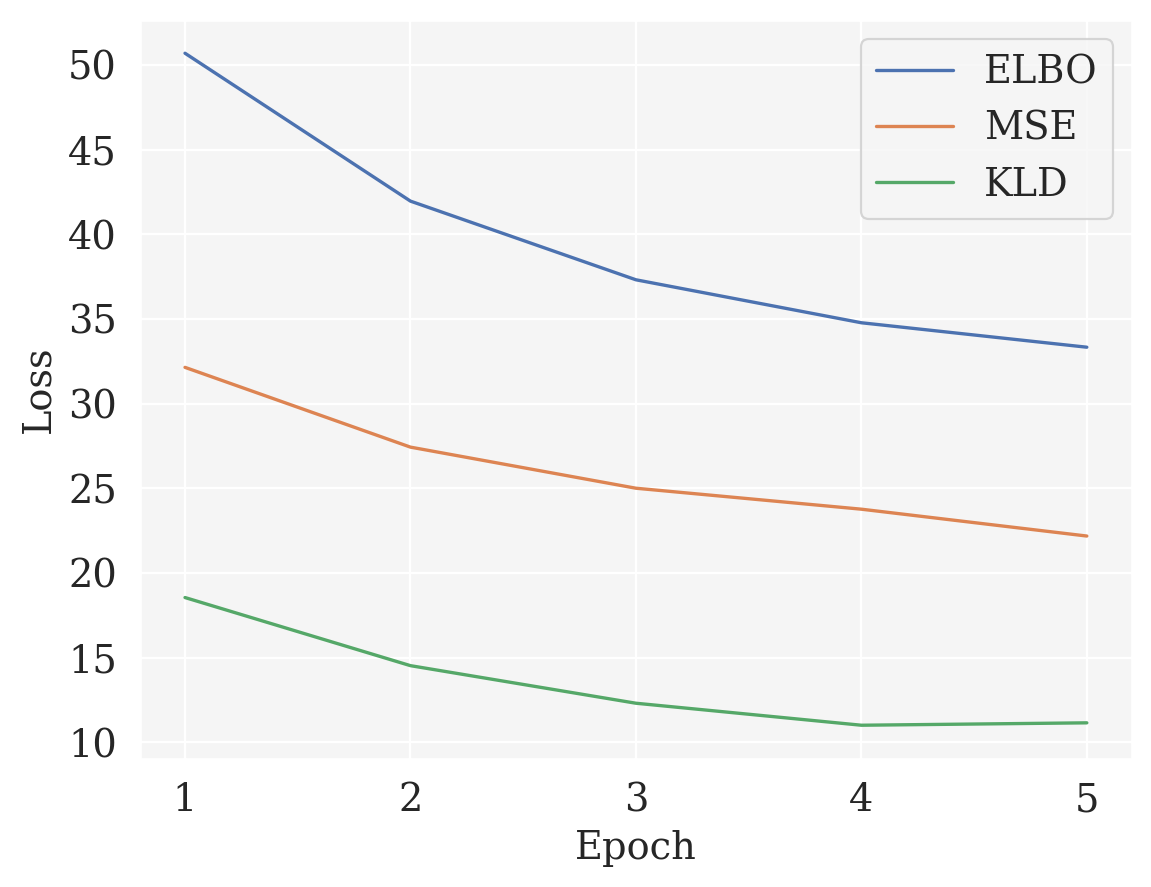

In [15]:
fig, ax = plt.subplots()
ax.plot(df["epoch"], df["elbo"], label="ELBO")
ax.plot(df["epoch"], df["mse"], label="MSE")
ax.plot(df["epoch"], df["kld"], label="KLD")
ax.set(xlabel="Epoch", ylabel="Loss")
ax.legend()
plt.show()

In [9]:
comparison.shape

(16, 28, 28, 1)

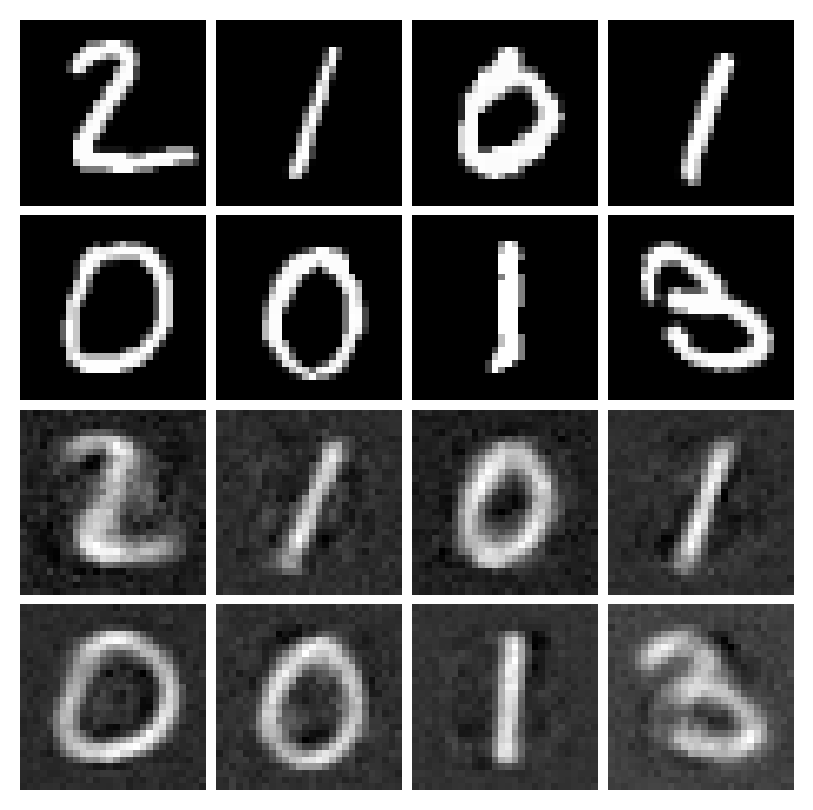

In [10]:
plot_digits(comparison)
plt.show()

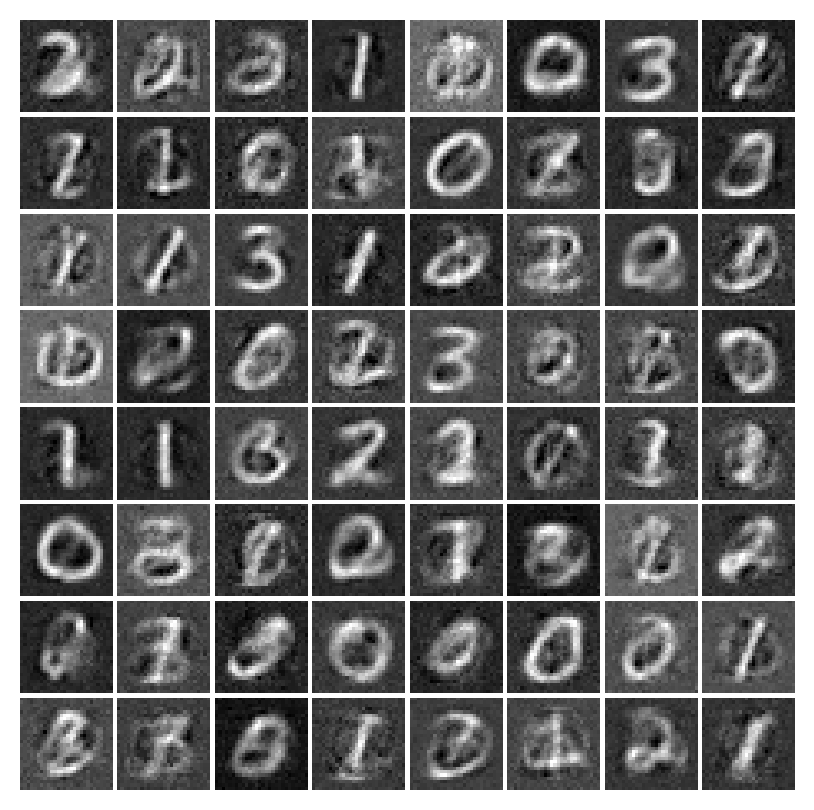

In [11]:
plot_digits(sample)
plt.show()